In [356]:
from scipy.io import wavfile
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

Version 2 new features:
- New feature detection: Low pitch low frequency fourier transform peak detection (to possibly find BPM?)
- Local pitch coherence:
    Local pitch coherence determined by variance of fft spectrum over a two second time period in a specific band, find means of these variances to determine the pitch coherence value for a frequency band

DATA PROCESSING

In [357]:
#returns the variance of the normalized data
def abs_div(data):
    data_norm = data/(np.max(data))
    data_abs = np.abs(data_norm)  
    data_avg = np.average(data_abs)
    data_var = np.power((data_abs - data_avg),2)
    return np.average(data_var)

In [358]:
#function for smoothing data
def smoothed(data):
    smooth = np.empty(data.size-400, dtype=float)
    for x in range(200,data.size-200):
        avg = np.average(data[x-200:x+200])
        smooth[x-200] = avg
    return smooth

In [359]:
def findMax(array):
    max = np.max(array)
    for x in range(0, array.size):
        if array[x] == max:
            return x
    return x

In [360]:
def dataProcessing(audio):
    #Inport audio file
    rate, data = wavfile.read(audio)

    #Output Data Array: 
    #Index 0: Average Intensity (relative to max)
    #Index 1: Variance of Normalized Intensity Data
    #Index 2-8: Relative Fractions of Average Freqency Intensities
    #Index 9-15: Variance of Normalized Frequency Band Intensity Data
    #Index 16-22: Local Squared Difference of Data and 400-sample Region for Frequency Bands
    #Index 23: BPM estimation off of low-frequency fourier peak
    output_data = np.empty(24, dtype=float)

    #changes data into usable format
    data = np.transpose(data)[0]
    #finds the absolute value of the normalized data, and then finds the average and inputs into the output array
    data_abs = np.abs(data/(np.max(data)))
    data_avg = np.average(data_abs)
    output_data[0] = data_avg
    #finds the variance of the normalized data, and then puts it into the output array
    output_data[1] = abs_div(data)

    #BPM analysis
    fft_out = fft(data)
    frequencies = np.linspace(0,1,len(data)) * rate
    cutoff_low = int((2 / rate * len(data)))
    cutoff = int((10 / rate) * len(data))
    beat_peak = findMax(fft_out[cutoff_low:cutoff]) + cutoff_low
    output_data[23] = frequencies[beat_peak]

    #converts spectrum into array of time and frequencies from fft
    spectrum, freqs, t, im = plt.specgram(data, Fs = rate, NFFT = 2000)

    #finds the rows which divide up the spectrum data into the frequency bands
    x = 0
    i = 1
    limits = np.empty(8, dtype=int)
    #gives a reference array for the sections 
    sections = [0,200,500,800,1500,2000,3000,np.max(freqs)]
    for r in freqs:
        if ((i == 1) & (r >= sections[1])):
            limits[1] = int(x)
            i += 1
        if ((i == 2) & (r >= sections[2])):
            limits[2] = int(x)
            i += 1
        if ((i == 3) & (r >= sections[3])):
            limits[3] = int(x)
            i += 1
        if ((i == 4) & (r >= sections[4])):
            limits[4] = int(x)
            i += 1
        if ((i == 5) & (r >= sections[5])):
            limits[5] = int(x)
            i += 1
        if ((i == 6) & (r >= sections[6])):
            limits[6] = int(x)
            i += 1
        x += 1
    #Ends of the limits array represent the bottom and upper ends of the sound spectrum
    limits[7] = int(freqs.size)
    limits[0] = 0

    #Create an array for the smoothed variance values of our dataset, and the relative intensity fractions of our bands
    smooth_vals = np.empty(7, dtype=float)
    intensity_fractions = np.empty(7, dtype=float)

    #Iterate through our frequency bands, performing calculations on different sections
    for x in range(0,7):
        #Copy the data for an array into another matrix, with the row transposed to represent all the data at a certain timepoint
        freq_data = np.transpose(np.array(spectrum[limits[x]:limits[x+1]]))
        #Sum up all of the data values for a specific timepoint to find the total for the frequency range at a given time
        range_intensity = np.empty(len(freq_data), dtype = float)
        for i in range(len(range_intensity)):
            range_intensity[i] = np.sum(freq_data[i])
        #Put the average total intensity for each range into the intensity fractions array
        intensity_fractions[x] = np.average(range_intensity)
        #Normalize range intensity after storing the relative average fractions
        range_intensity = range_intensity/(np.max(range_intensity))
        #Find the variance between the data and the smoothed data, determining how much intenisty varies for each frequency range
        smooth_diff = np.power(range_intensity[200:range_intensity.size-200] - smoothed(range_intensity), 2)
        #Average out the smoothed variance and send that to the smooth vals array
        smooth_vals[x] = np.average(smooth_diff)
        #Send the variance of the range_intensity normalized data to the output data array
        output_data[x+9] = abs_div(range_intensity)
    
    #Divide intensity fractions by their sum, in order to find relative frations
    intensity_fractions = intensity_fractions/np.sum(intensity_fractions)

    #Copy intensity fractions to output data
    n = 2
    for x in intensity_fractions:
        output_data[n] = x
        n += 1

    #Copy smooth vals to output data
    n = 16
    for x in smooth_vals:
        output_data[n] = x
        n += 1
    
    #Return our complete output data for analysis for the data sample
    return output_data


LOADS ALL DATA VALUES FOR REGRESSION

In [361]:
audio_EDM = ['Audio/EDM/01-dont-let-me-down_IBFUjKEE.wav', 'Audio/EDM/01-faded_ZkQNNMHm.wav','Audio/EDM/01-fractures-feat-nevve_nOvUVQHe.wav', 'Audio/EDM/01-friends_qvpJ4Lo4.wav', 'Audio/EDM/01-good-things-fall-apart-with-jon-bellion_xpYFEBMe.wav', 'Audio/EDM/01-happier_GNrA2lNl.wav', 'Audio/EDM/01-ignite-2016-league-of-legends-world-championship_4NqYagH7.wav', 'Audio/EDM/01-in-the-name-of-love_jKlJDXPg.wav', 'Audio/EDM/01-legends-never-die_5mDvGncl.wav', 'Audio/EDM/01-monody-feat-laura-brehm_qU3F5YI0.wav', 'Audio/EDM/01-never-be-alone_Jv12eRl8.wav', 'Audio/EDM/01-silence_qpg8yd6l.wav', 'Audio/EDM/01-stay-with-justin-bieber_ltjXbsxI.wav', 'Audio/EDM/01-sweet-dreams_e3fA34lv.wav', 'Audio/EDM/01-this-is-what-you-came-for_InpQYKrj.wav', 'Audio/EDM/01-titanium-feat-sia_aQb8tAes.wav', 'Audio/EDM/01-wake-me-up_KuOoUs4s.wav', 'Audio/EDM/02-animals_pk7DZset.wav', 'Audio/EDM/02-the-nights_VYEGBCc5.wav', 'Audio/EDM/08-summer_IiUQlAi9.wav']
audio_Acoustic = ['Audio/Acoustic/01-beside-you_DbI1HoZp.wav', 'Audio/Acoustic/01-blue-jeans_KtEm5Rew.wav', 'Audio/Acoustic/01-comethru_xaPhmWu1.wav', 'Audio/Acoustic/01-every-summertime_JhqMP4vf.wav', 'Audio/Acoustic/01-forever_I7GFvUWO.wav', 'Audio/Acoustic/01-glimpse-of-us_eaUMFHHd.wav', 'Audio/Acoustic/01-i-love-you-3000_MhUDZ0Tw.wav', 'Audio/Acoustic/01-its-you_F8gy2m2i.wav', 'Audio/Acoustic/01-lowkey_l70yk4Kc.wav', 'Audio/Acoustic/01-over-85_qAs8hOpI.wav', 'Audio/Acoustic/01-paragraphs_YX95fhg4.wav', 'Audio/Acoustic/02-all-the-stars-with-sza_scR5myEg.wav', 'Audio/Acoustic/02-idk-you-yet_rw1jHoGu.wav', 'Audio/Acoustic/02-paris-in-the-rain_upCjJwOS.wav', 'Audio/Acoustic/02-slow-dancing-in-the-dark_7DuXBFev.wav', 'Audio/Acoustic/03-blue_bizdmoGR.wav', 'Audio/Acoustic/03-nothing_FvdnRUPW.wav', 'Audio/Acoustic/05-scared_9tLiNUgS.wav', 'Audio/Acoustic/06-heartbreak-anniversary_EGZ7xVAV.wav', 'Audio/Acoustic/06-when-i-was-your-man_QLPuoeTU.wav']
audio_HipHop = ['Audio/Hip Hop/01-broccoli_T8E78OZY.wav', 'Audio/Hip Hop/01-highest-in-the-room_St5D6Qyd.wav', 'Audio/Hip Hop/01-industry-baby-feat-jack-harlow_WcNnacu6.wav', 'Audio/Hip Hop/01-trap-queen_8G2DO5e0.wav', 'Audio/Hip Hop/01-whats-poppin_s84KOU9F.wav', 'Audio/Hip Hop/02-bank-account_1tzsEOaC.wav', 'Audio/Hip Hop/02-rapstar_KzWdE0Dp.wav', 'Audio/Hip Hop/03-goin-baby_vdwhRP6r.wav', 'Audio/Hip Hop/03-lucid-dreams_Re1GBOPz.wav', 'Audio/Hip Hop/03-ni-as-in-paris_4Gd5Qr2o.wav', 'Audio/Hip Hop/04-sad_4MGXMNw7.wav', 'Audio/Hip Hop/04-sad_4MGXMNw7.wav', 'Audio/Hip Hop/05-black-beatles_4P3MObDG.wav', 'Audio/Hip Hop/05-dollaz-on-my-head-feat-young-thug_rZnBd4vw.wav', 'Audio/Hip Hop/05-go-stupid_JX0u37ij.wav', 'Audio/Hip Hop/05-gods-plan_npCgxuP6.wav', 'Audio/Hip Hop/07-burning-up-feat-the-kid-laroi_glVulTwh.wav', 'Audio/Hip Hop/07-godzilla-feat-juice-wrld_HyXxbZYa.wav', 'Audio/Hip Hop/07-let-it-eat-feat-ugly-god_hy86qqow.wav', 'Audio/Hip Hop/09-mo-bamba_qkqDH4UF.wav', 'Audio/Hip Hop/14-jimmy-cooks-feat-21-savage_5IZHBAha.wav']

In [362]:
test_audio_EDM = ['Audio/Testing/05 Clarity.wav', 'Audio/Testing/07 Don\'t You Worry Child.wav', 'Audio/Testing/03 We Found Love.wav', 'Audio/Testing/01 Turn Down for What.wav', 'Audio/Testing/03 Feel So Close - Radio Edit.wav']
test_audio_RB = ['Audio/Testing/01 CHICKEN TENDIES.wav', 'Audio/Testing/03 Die For You.wav', 'Audio/Testing/07-Talking-to-the-Moon.wav', 'Audio/Testing/01 Shouldn\'t Be.wav', 'Audio/Testing/04 Nothing\'s the Same.wav']
test_audio_HipHop = ['Audio/Testing/01 Gorilla Grip.wav', 'Audio/Testing/03 Diamonds Dancing (feat. Travis Scott).wav', 'Audio/Testing/04 wokeuplikethis.wav', 'Audio/Testing/18-Monëy-so-big.wav', 'Audio/Testing/04 EA (feat. 21 Savage)_1.wav']

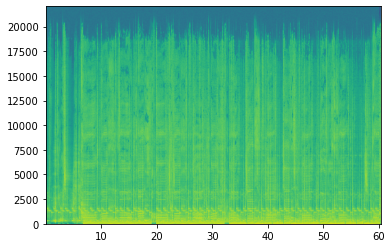

In [363]:
#Genres: 0 - EDM, 1 - Acoustic, 2 - Hip Hop
x = 20
total_data = np.empty(shape = [3, x, 24], dtype=float)

#Load in data for EDM
for i in range(0,x):
    total_data[0][i] = dataProcessing(audio_EDM[i])

#Load in data for Acoustic
for i in range(0,x):
    total_data[1][i] = dataProcessing(audio_Acoustic[i])

#Load in data for Hip_Hop
for i in range(0,x):
    total_data[2][i] = dataProcessing(audio_HipHop[i])


In [364]:
def var_calc(mean, values):
    return np.average(np.power((values - mean),2))

In [365]:
def findMin(array):
    max = np.min(array)
    for x in range(0, array.size):
        if array[x] == max:
            return x
    return x

Building a Network

In [366]:

# Define the neural network
class DataNet(nn.Module):
  def __init__(self):

    super(DataNet, self).__init__()

    self.linear1 = nn.Linear(24, 64)
    self.linear2 = nn.Linear(64, 12)
    self.linear3 = nn.Linear(12, 3)

  def forward(self, x):
    # Apply the ReLU activation function to the output of the first linear layer
    x = F.relu(self.linear1(x))

    # Apply the ReLU activation function to the output of the second linear layer
    x = F.relu(self.linear2(x))

    # Apply the ReLU activation function to the output of the third linear layer
    x = F.relu(self.linear3(x))

    return x



In [367]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, statements, truth):
        self.statements = statements
        self.truth = truth
    def __getitem__(self, index):
        return self.statements[index], self.truth[index]
    def __len__(self):
        return len(self.truth)

In [368]:
dataModel = DataNet()
device = torch.device('cpu')
dataModel.to(device)
criterion = nn.CrossEntropyLoss()
Optimizer = torch.optim.Adam(dataModel.parameters(), weight_decay=0.01)

In [369]:
data_tensor = torch.from_numpy(total_data).to(torch.float)
data_tensor = data_tensor.reshape(60,24)
print(data_tensor.size())

torch.Size([60, 24])


In [370]:
#Create labels tensor
#Genres: 0 - EDM, 1 - Acoustic, 2 - Hip Hop
x = 20
size = x * 3
total_labels = torch.empty(size, dtype=torch.long)

#Load in data for EDM
for i in range(0,x):
    total_labels[i] = 0

#Load in data for Acoustic
for i in range(0,x):
    total_labels[i+x] = 1

#Load in data for Hip_Hop
for i in range(0,x):
    total_labels[i+2*x] = 2


In [371]:
dataset = CustomDataset(data_tensor, total_labels)
TrainDataLoader = torch.utils.data.DataLoader(dataset, batch_size=6, shuffle=True)

In [372]:
def train_epoch(model, train_loader, optimizer, criterion, device):
    model.train()
    for i, batch in enumerate(train_loader):
        batch_inputs, batch_labels = batch
        batch_inputs = batch_inputs.to(device)
        batch_labels = batch_labels.to(device)
        predictions = model(batch_inputs)
        loss = criterion(predictions, batch_labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    print ('End of epoch loss:', round(loss.item(), 3))


In [373]:
for epoch in range(10):
    print("Epoch: ", epoch+1)
    train_epoch(dataModel, TrainDataLoader, Optimizer, criterion, device)

Epoch:  1
End of epoch loss: 1.196
Epoch:  2
End of epoch loss: 1.188
Epoch:  3
End of epoch loss: 1.18
Epoch:  4
End of epoch loss: 1.142
Epoch:  5
End of epoch loss: 1.14
Epoch:  6
End of epoch loss: 1.07
Epoch:  7
End of epoch loss: 1.073
Epoch:  8
End of epoch loss: 1.134
Epoch:  9
End of epoch loss: 1.135
Epoch:  10
End of epoch loss: 1.128


In [374]:
x = 5
size = x * 3
test_labels = torch.empty(size, dtype=torch.long)

#Load in data for EDM
for i in range(0,5):
    total_labels[i] = 0

#Load in data for Acoustic
for i in range(0,5):
    total_labels[i+x] = 1

#Load in data for Hip_Hop
for i in range(0,5):
    total_labels[i+2*x] = 2

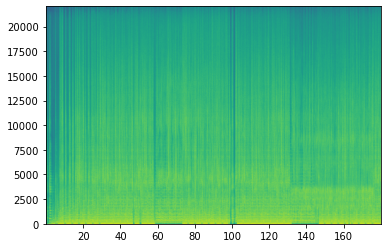

In [375]:
#Genres: 0 - EDM, 1 - Acoustic, 2 - Hip Hop
x = 5
test_data = np.empty(shape = [3, x, 24], dtype=float)

#Load in data for EDM
for i in range(0,x):
    test_data[0][i] = dataProcessing(test_audio_EDM[i])

#Load in data for Acoustic
for i in range(0,x):
    test_data[1][i] = dataProcessing(test_audio_RB[i])

#Load in data for Hip_Hop
for i in range(0,x):
    test_data[2][i] = dataProcessing(test_audio_HipHop[i])

In [376]:
test_tensor = torch.from_numpy(test_data).to(torch.float)
test_tensor = test_tensor.reshape(15,24)
print(data_tensor.size())

torch.Size([60, 24])


In [377]:
test_dataset = CustomDataset(test_tensor, test_labels)
TestDataLoader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)

In [378]:
dataModel.eval()
correct = 0
total = 15
for data in iter(TestDataLoader):
    batch_inputs, batch_labels = data
    prediction = dataModel(batch_inputs).argmax()
    correct += (prediction==batch_labels).item()
print(100 * correct/total, "%")

80.0 %


In [379]:
torch.save(dataModel.state_dict(),'./DataModelworking.pt')